# Aggregate Planning with QUASAR
## Modeling the Decision Problem

Stochastic decision problems in QUASAR can be formulated by using the same type of mathematical expressions as they are common in linear programming. This requires defining a set of decision variables, an objective function, as well as a set of constraints.

We begin by importing the library and creating a *DecisionProblem* that contains our model formulation.

In [21]:
from pyquasar import *

### Variables & Constraints
Variables have to be linked to a decision stage and are defined by addVariable.

Constraints can be formulated using simple algebraic expressions. In the problem at hand the most important constraints link the variables *sell*, *produce* and *inventory*. The corresponding constraint is

$$\text{inventory}_t = \text{inventory}_{t-1} - \text{sell}_t + \text{produce}_t$$

Note that *demand* is the random demand for the product - a specific model for this randomness will be specified below.
### Objective function
With our constraints in place, we finally have to include the objective function, which consists of the costs for buying capacity, the cost for production, the revenue from sales, and cost for maintaining inventory.

$$\max \ \left\{ \sum_{t=1}^{T} \text{sell}_{t} \times \text{price} - \sum_{t=1}^{T} \text{produce}_{t} \times \text{prod_cost} - \text{capacity_cost} \times \text{capacity} - \text{inventory_cost} \times \text{inventory}_t \right\}$$

In [7]:
num_months = 12
capacity_cost = 1
inventory_cost = 0.2
prod_cost = 4
price = 5
init_inventory = 0

model = DecisionProblem()
capacity = model.add_variable(0,"capacity")
model += capacity <= 1000
prev_inventory = init_inventory
for t in range(num_months):
    inventory, produce, sell = model.add_variables(t, "inventory", "produce", "sell")
    model += inventory <= 1000

    #inventory balance
    model += inventory == prev_inventory - sell + produce

    #bounds
    model += sell <= rand("demand")
    model += sell <= prev_inventory
    model += produce <= capacity
    prev_inventory = inventory
    
    # objective function
    model += price*sell - prod_cost*produce - inventory_cost*inventory

# capacity cost in the objective
model += -capacity_cost*capacity

##Modeling the Stochastic Process
Before we can pass the *DecisionProblem* into the optimizer, we have to specify the *MarkovProcess* that drives the evolution of our random variables over time. QUASAR provides a number of classes that allow us to specify different types of stochastic processes.

1. Univariate processes with only one state variable

2. Multivariate processes with multiple state variables

For the sake of simplicity, we choose a simple geometric AR(1) model for the demand. In this model, demand cannot be zero by definition, but is correlated across time, which is often the case in practice.

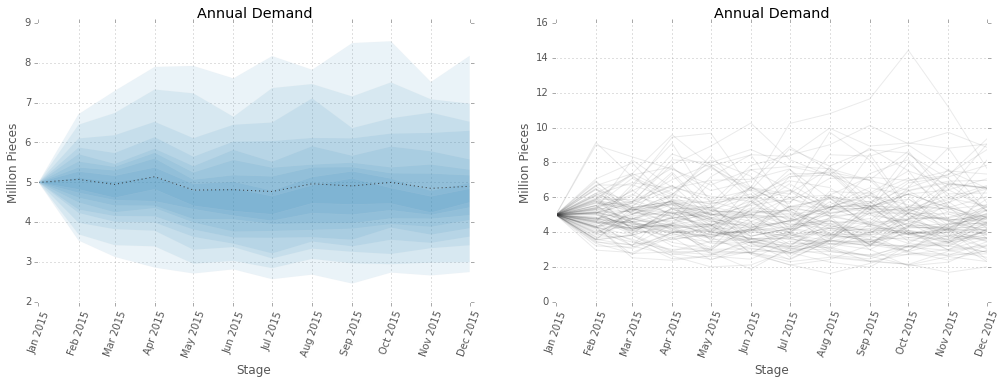

In [8]:
ar_model = ARModel(name="demand",
                  constant=0.3, 
                  sigma=0.2, 
                  ar_coefficients=[0.8], 
                  initial_state=[5.0], 
                  log_transform=True)
sim = ar_model.simulate(num_stages=num_months, sample_size=100)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,5))
sim.set_time_index(start='2015-01',freq='MS')
sim.demand.fanchart(ax=ax1, ylabel='Million Pieces', title="Annual Demand")
sim.demand.spaghetti(ax=ax2, ylabel='Million Pieces', title="Annual Demand")

## Solving the problem

Putting everything together, we can now generate a lattice and solve the model. The solver runs in a separate thread, so that the notebook is not blocked. To wait for the solver to finish, the *join()* method must be called.

In [9]:
opt = DynamicOptimizer(model, ar_model, num_nodes=50)
opt.solve()
opt.join()

Using the stats *property* of the *opt* object, we can check the status during the solution process.

In [10]:
opt.stats.tail()

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
35,32.43,32.19,1.78,8147,19319,1
36,32.43,32.73,1.84,8338,19871,1
37,32.42,33.42,1.82,8637,20423,1
38,32.38,33.18,1.81,8938,20975,1
39,32.37,32.36,0.68,9130,21527,1


### Plotting bounds
The ADDP upper bound an the lattice lower bound can be visualized with *DynamicOptimizer.plot()*.

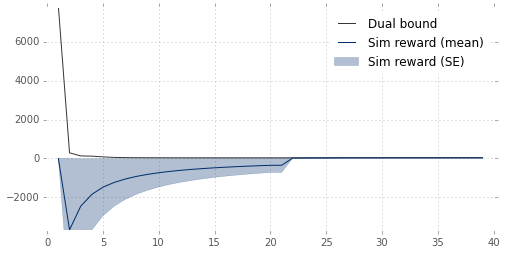

In [11]:
opt.plot()

## Inspecting the solution
To inspect the solution, we simulate the policy on the lattice.

In [12]:
policy = opt.policy
sim = policy.simulate(sample_size = 1000)
sim.set_time_index(start='2015-01',freq='MS')

The result of the simulation is stored in a Pandas dataframe which hows the demand state, the immediate reward, the decision as well as the shadow prices of the time coupling variables. Since this is a Pandas dataframe, analyszing the simulation output is a breeze. 

Let us only take look at the first sample path of our optimized policy.

In [13]:
sim.head(num_months)

rewards decision                            shadow_price  \
                  rewards     sell inventory capacity produce    inventory   
series stage                                                                 
0      2015-01-01  -30.81     0.00      5.92     5.92    5.92         4.26   
       2015-02-01    7.16     4.13      4.92     5.92    3.13         4.10   
       2015-03-01    5.71     3.89      4.26     5.92    3.22         4.18   
       2015-04-01    2.79     3.42      4.20     5.92    3.37         4.06   
       2015-05-01    1.55     3.69      4.51     5.92    4.00         4.30   
       2015-06-01    1.14     4.46      5.09     5.92    5.03         4.26   
       2015-07-01    3.99     3.80      4.80     5.92    3.51         4.14   
       2015-08-01   -0.88     4.80      5.92     5.92    5.92         4.39   
       2015-09-01    4.74     5.92      5.92     5.92    5.92         4.38   
       2015-10-01    4.74     5.92      5.92     5.92    5.92         4.46   
       2015-11-01    8.03     5.92      5.14     5.92    5.14         4.28   
       2015-12-01   25.70     5.14      0.00      nan    0.00          nan   

                            state  
                  capacity demand  
series stage                       
0      2015-01-01     0.90   5.00  
       2015-02-01     0.49   4.13  
       2015-03-01     0.31   3.89  
       2015-04-01     0.24   3.42  
       2015-05-01     0.20   3.69  
       2015-06-01     0.29   4.46  
       2015-07-01     0.08   3.80  
       2015-08-01     0.34   5.80  
       2015-09-01     0.20   6.10  
       2015-10-01     0.03   6.19  
       2015-11-01     0.00   6.66  
       2015-12-01      nan   7.39

### The *true* profit distribution
The simulated profit of the policy under the AR demand model may deviate from the simulated lower bound if not enough scenarios have been used to construct the lattice. Let us therefore take a look at the reward distribution.

In [14]:
sim.rewards.groupby_series.sum().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rewards,1000.00,31.94,6.70,14.90,26.93,31.82,36.84,46.21


### Getting first stage decision
The production capacity is a first stage decision variable. Hence, it is independent of the scenarios and only has one deterministic value for all scenarios.

In [15]:
print 'Production capacity: %.2f'%policy.first_stage_solution().decision['capacity']

Production capacity: 5.92


### Plotting stochastic decision variables
The variables *inventory*, *produce*, and *sell* vary with different scenarios and are therefore random. We use a fanplot to visualize this randomness over time.

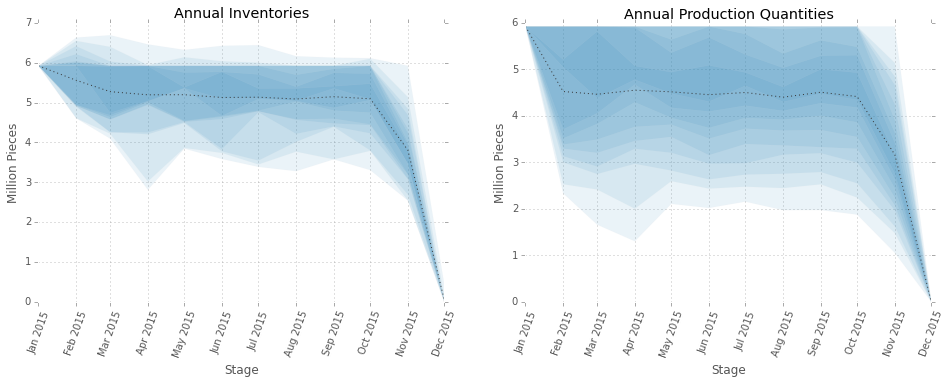

In [16]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,5))
sim.decision['inventory'].fanchart(ax1, ylabel='Million Pieces', title="Annual Inventories")
sim.decision['produce'].fanchart(ax2, ylabel='Million Pieces', title="Annual Production Quantities")

###Service Level
The service level is the percentage of demand that can be fulfilled from stock. The $\alpha$-service is event-oriented counting the percentage of in-stock instances, where as the $\beta$-service is quantity-oriented accumulating the percentage of demand served from stock.

In [17]:
alpha = np.sign(sim.state['demand']-sim.decision['inventory']).clip(0).mean()
beta = 1-(sim.state['demand']-sim.decision['inventory']).sum()/sim.state['demand'].sum()
print("%s-Service = %.3f"%(u"\u03B1",alpha))
print("%s-Service = %.3f"%(u"\u03B2",beta))

α-Service = 0.329
β-Service = 0.970


###Exporting the simulation result
We can easily export the results from simulating the optimal policy into a CSV for further usage elsewhere.

In [18]:
sim.to_csv('agg_model.csv')